In [1]:
!pip -q install -U datasets accelerate evaluate  tabulate protobuf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 6.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 9.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 35.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
# MRPC + T5-base + LoRA (PEFT) -- AdaRank implementation with proper callbacks and visualizations
# Lightweight sanity check version
import os, math, random, json
from dataclasses import dataclass
from typing import List, Dict
import numpy as np
import torch
from datasets import load_dataset
import evaluate
from transformers import (AutoTokenizer, AutoModelForSeq2SeqLM,
                          DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments, TrainerCallback, TrainerControl, TrainerState)
from peft import LoraConfig, TaskType, get_peft_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress
from torch.amp import GradScaler
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
# --------------------------
# Data: GLUE/MRPC
# --------------------------
def load_mrpc():
    ds = load_dataset("glue", "mrpc")
    return ds # train, validation, test
tokenizer = AutoTokenizer.from_pretrained("t5-base")
collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True, return_tensors="pt")
def to_t5_format_mrpc(example):
    # MRPC: paraphrase classification - are these two sentences paraphrases?
    inp = f"mrpc sentence1: {example['sentence1']} sentence2: {example['sentence2']} paraphrase:"
    label = "equivalent" if example["label"] == 1 else "not equivalent"
    return {"input_text": inp, "target_text": label}
def tokenize_batch(batch, max_in=128, max_out=4):
    inps = tokenizer(batch["input_text"], max_length=max_in, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        outs = tokenizer(batch["target_text"], max_length=max_out, truncation=True, padding="max_length")
    inps["labels"] = outs["input_ids"]
    return inps
# --------------------------
# LoRA model factory
# --------------------------
def build_lora_t5(rank: int, lora_alpha=None, lora_dropout=0.0):
    if lora_alpha is None:
        lora_alpha = 2 * rank
    base = AutoModelForSeq2SeqLM.from_pretrained("t5-base")
    base.requires_grad_(False)
    peft_cfg = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        r=rank,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=["q","v"],
        inference_mode=False
    )
    model = get_peft_model(base, peft_cfg, adapter_name=f"rank_{rank}")
    return model
# --------------------------
# Metrics - Updated for MRPC
# --------------------------
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
def decode_to_label_ids(pred_ids):
    # Handle padding and special tokens properly
    if isinstance(pred_ids, torch.Tensor):
        pred_ids = pred_ids.cpu().numpy()
  
    # Replace -100 (ignore index) with pad token
    pred_ids = np.where(pred_ids == -100, tokenizer.pad_token_id, pred_ids)
  
    # Handle 2D arrays (batch_size x sequence_length)
    if len(pred_ids.shape) > 1:
        # Take the first non-pad token for each sequence
        texts = []
        for seq in pred_ids:
            # Find first non-pad token
            non_pad_idx = np.where(seq != tokenizer.pad_token_id)[0]
            if len(non_pad_idx) > 0:
                # Decode just the first non-pad token
                texts.append(tokenizer.decode([seq[non_pad_idx[0]]], skip_special_tokens=True))
            else:
                texts.append("")
    else:
        texts = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
  
    def map_txt(t):
        t = t.strip().lower()
        if "equivalent" in t and "not" not in t: return 1
        if "not" in t and "equivalent" in t: return 0
        # Fallback logic
        if "yes" in t or "true" in t or "pos" in t: return 1
        if "no" in t or "false" in t or "neg" in t: return 0
        return 1 if len(t) > 0 and t[0] in ['y', 't', 'e', '1'] else 0
  
    return np.array([map_txt(t) for t in texts], dtype=int)
def compute_metrics(eval_pred):
    preds, labels = eval_pred
  
    # Handle different shapes of labels
    if len(labels.shape) > 1:
        # For token IDs, we need to decode them
        y_true = decode_to_label_ids(labels)
    else:
        # If already processed to class indices
        y_true = labels
  
    y_hat = decode_to_label_ids(preds)
  
    # Filter out invalid predictions (where decoding failed)
    valid_mask = (y_hat >= 0) & (y_true >= 0)
    if not np.any(valid_mask):
        return {"accuracy": 0.0, "f1": 0.0}
  
    y_hat = y_hat[valid_mask]
    y_true = y_true[valid_mask]
  
    acc = acc_metric.compute(predictions=y_hat, references=y_true)["accuracy"]
    f1 = f1_metric.compute(predictions=y_hat, references=y_true, average="macro")["f1"]
  
    return {"accuracy": acc, "f1": f1}
# --------------------------
# Adaptive-rank controller - FIXED CALLBACK IMPLEMENTATION
# --------------------------
@dataclass
class AdaRankCfg:
    r0: int = 4 # Start with even smaller rank for MRPC
    r_max: int = 64 # Lower max rank since MRPC is smaller
    alpha: int = 2 # Smaller steps for fine-grained control
    tol: float = 0.10 # Slightly higher tolerance for smaller dataset
    check_every: int = 50 # Check more frequently since dataset is smaller
    warmup_steps: int = 50 # Shorter warmup
class RankController(TrainerCallback):
    def __init__(self, cfg: AdaRankCfg):
        super().__init__()
        self.cfg = cfg
        self.current_r = cfg.r0
        self.history = []
        self.step_counter = 0
        self.trainer = None  # will be set right after trainer creation

    def _set_rank(self, new_r: int):
        new_r = int(min(new_r, self.cfg.r_max))
        if new_r == self.current_r:
            return
    
        print(f"\nRank inflation: {self.current_r} to {new_r}")
    
        # === 1. Merge current adapter ===
        print("  → Merging current LoRA into base model...")
        merged = self.trainer.model.merge_and_unload()
        if hasattr(merged, "peft_config"):
            del merged.peft_config
    
        # === 2. Create new higher-rank model ===
        print(f"  → Creating new LoRA with rank={new_r}")
        new_cfg = LoraConfig(
            task_type=TaskType.SEQ_2_SEQ_LM,
            r=new_r,
            lora_alpha=2 * new_r,
            lora_dropout=0.0,
            target_modules=["q", "v"],
            inference_mode=False,
        )
        new_model = get_peft_model(merged, new_cfg).to(device)
    
        # === 3. FULLY REPLACE model + optimizer + scaler ===
        print("  → Replacing model in trainer + re-preparing with Accelerate")
        self.trainer.model_wrapped = new_model
        self.trainer.model = self.trainer.accelerator.prepare(new_model)
    
        print("  → Creating new optimizer...")
        self.trainer.create_optimizer()
    
        print("  → Creating new scheduler...")
        total_steps = (
            len(self.trainer.train_dataset) //
            (self.trainer.args.per_device_train_batch_size *
             self.trainer.args.gradient_accumulation_steps *
             max(1, self.trainer.args.world_size))
            * self.trainer.args.num_train_epochs
        )
        self.trainer.create_scheduler(num_training_steps=total_steps)
    
        # === 4. THE REAL FIX: Re-create Accelerate's scaler from scratch ===
        if self.trainer.args.fp16:
            print("  → Re-creating fresh GradScaler (this fixes the inf-check error)")
            from torch.amp import GradScaler
            new_scaler = GradScaler('cuda')
            self.trainer.accelerator._optimizers = [self.trainer.optimizer]
            self.trainer.accelerator.scaler = new_scaler
            self.trainer.scaler = new_scaler
            print(f"     New scaler created: {id(new_scaler)}")
    
        # === 5. Finalize ===
        self.current_r = new_r
        print(f"Rank inflation SUCCESSFUL → current rank = {self.current_r}\n")

    def on_train_begin(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        print(f"AdaRank initialized – starting rank: {self.current_r}")
        return control

    def on_step_end(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        self.step_counter += 1
        step = state.global_step

        # Grab latest loss
        loss = None
        if state.log_history and "loss" in state.log_history[-1]:
            loss = state.log_history[-1]["loss"]

        if (step >= self.cfg.warmup_steps and 
            step % self.cfg.check_every == 0 and 
            loss is not None and 
            loss > self.cfg.tol and 
            self.current_r < self.cfg.r_max):
            print(f"Step {step} | Loss {loss:.4f} > tol → inflating rank")
            self._set_rank(self.current_r + self.cfg.alpha)

        self.history.append({"step": step, "rank": self.current_r, "loss": loss})

        return control

    def on_train_end(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        print(f"Training finished – final rank: {self.current_r}")
        return control
# --------------------------
# Training - Optimized for MRPC
# --------------------------


from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import json, os

def run_experiment_pytorch(
    out_dir="./t5base_mrpc_adarank_pytorch",
    epochs=10,
    lr=3e-4,
    bs=16,
    grad_accum=4,
    r0=4,
    r_max=128,
    alpha=4,
    tol=0.15,
    check_every=230,
    warmup_steps=100,
    val_check_every=230):  

    # === Data ===
    ds = load_mrpc()
    tr = ds["train"].map(to_t5_format_mrpc, remove_columns=ds["train"].column_names)
    va = ds["validation"].map(to_t5_format_mrpc, remove_columns=ds["validation"].column_names)
    tr_tok = tr.map(lambda b: tokenize_batch(b), batched=True, remove_columns=tr.column_names).with_format("torch")
    va_tok = va.map(lambda b: tokenize_batch(b), batched=True, remove_columns=va.column_names).with_format("torch")

    train_loader = DataLoader(tr_tok, batch_size=bs, shuffle=True, collate_fn=collator)
    val_loader   = DataLoader(va_tok, batch_size=bs*2, collate_fn=collator)

    # === Model ===
    model = build_lora_t5(rank=r0).to(device)
    model.train()

    # === Optimizer & Scheduler ===
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs // grad_accum
    scheduler = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_steps)

    # === Rank Controller State ===
    current_rank = r0
    history = []
    global_step = 0
    effective_batch = 0

    os.makedirs(out_dir, exist_ok=True)

    print("STARTING TRAINING WITH ADARANK (Pure PyTorch + tqdm)")

    for epoch in range(epochs):
        print(f"\nEPOCH {epoch+1}/{epochs} | Current LoRA rank: {current_rank}")
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        for batch in pbar:
            global_step += 1
            effective_batch += 1

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss / grad_accum
            loss.backward()

            if effective_batch % grad_accum == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            # Log loss
            if global_step % 25 == 0:
                pbar.set_postfix({"loss": loss.item() * grad_accum, "rank": current_rank})

            # === AdaRank Logic ===
            if (global_step >= warmup_steps and
                global_step % check_every == 0 and
                loss.item() * grad_accum > tol and
                current_rank < r_max):

                print(f"\nLOSS {loss.item()*grad_accum:.4f} > {tol} → INFLATING RANK {current_rank} → {current_rank + alpha}")

                # Merge current LoRA
                merged = model.merge_and_unload()
                if hasattr(merged, "peft_config"):
                    del merged.peft_config

                # Create new higher-rank model
                new_cfg = LoraConfig(
                    task_type=TaskType.SEQ_2_SEQ_LM,
                    r=current_rank + alpha,
                    lora_alpha=2 * (current_rank + alpha),
                    lora_dropout=0.0,
                    target_modules=["q", "v"],
                    inference_mode=False,
                )
                model = get_peft_model(merged, new_cfg).to(device)
                model.train()

                # Fresh optimizer (this is why it works!)
                optimizer = AdamW(model.parameters(), lr=lr)
                scheduler = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_steps)

                current_rank += alpha
                print(f"RANK INFLATED TO {current_rank} — TRAINING CONTINUES")

            history.append({
                "step": global_step,
                "epoch": epoch + effective_batch/len(train_loader),
                "loss": loss.item() * grad_accum,
                "rank": current_rank
            })

            # === Validation Check ===
            if global_step % val_check_every == 0:
                model.eval()
                val_loss_total = 0
                val_batches = 0
                with torch.no_grad():
                    for val_batch in val_loader:
                        val_batch = {k: v.to(device) for k, v in val_batch.items()}
                        val_outputs = model(**val_batch)
                        val_loss_total += val_outputs.loss.item()
                        val_batches += 1
                        if val_batches >= 5:  # Limit validation to save time
                            break
                avg_val_loss = val_loss_total / val_batches
                
                # Add validation loss to history
                history[-1]["val_loss"] = avg_val_loss
                print(f"Step {global_step} | Train Loss: {loss.item() * grad_accum:.4f} | Val Loss: {avg_val_loss:.4f} | Rank: {current_rank}")
                
                model.train()

    # Final validation at the end of training
    model.eval()
    preds, refs = [], []
    val_loss_total = 0
    val_batches = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            val_outputs = model(**batch)
            val_loss_total += val_outputs.loss.item()
            val_batches += 1
            
            generated = model.generate(**batch, max_length=4)
            pred_text = tokenizer.batch_decode(generated, skip_special_tokens=True)
            ref_text = tokenizer.batch_decode(batch["labels"], skip_special_tokens=True)
            preds.extend(pred_text)
            refs.extend(ref_text)

    avg_final_val_loss = val_loss_total / val_batches
    # Simple accuracy
    correct = sum(1 for p, r in zip(preds, refs) if p.strip().lower() == r.strip().lower())
    acc = correct / len(preds)
    print(f"Validation Accuracy: {acc:.4f}")
    print(f"Final Validation Loss: {avg_final_val_loss:.4f}")

    model.train()

    # Save results
    final_result = {
        "final_rank": current_rank,
        "val_accuracy": acc,
        "test_error": 1.0 - acc,
        "final_val_loss": avg_final_val_loss
    }
    with open(os.path.join(out_dir, "result.json"), "w") as f:
        json.dump(final_result, f, indent=2)
    with open(os.path.join(out_dir, "trajectory.json"), "w") as f:
        json.dump(history, f, indent=2)

    print(f"\nTRAINING COMPLETE!")
    print(f"Final LoRA rank: {current_rank}")
    print(f"Validation Accuracy: {acc:.4f}")
    print(f"Final Validation Loss: {avg_final_val_loss:.4f}")

    return {
        "trajectory": history,
        "results": final_result,
        "out_dir": out_dir
    }



In [7]:
results = run_experiment_pytorch()

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

STARTING TRAINING WITH ADARANK (Pure PyTorch + tqdm)

EPOCH 1/10 | Current LoRA rank: 4


Epoch 1:   0%|          | 0/230 [00:00<?, ?it/s]


LOSS 6.0849 > 0.15 → INFLATING RANK 4 → 8
RANK INFLATED TO 8 — TRAINING CONTINUES
Step 230 | Train Loss: 6.0849 | Val Loss: 4.0911 | Rank: 8

EPOCH 2/10 | Current LoRA rank: 8


Epoch 2:   0%|          | 0/230 [00:00<?, ?it/s]


LOSS 0.9481 > 0.15 → INFLATING RANK 8 → 12
RANK INFLATED TO 12 — TRAINING CONTINUES
Step 460 | Train Loss: 0.9481 | Val Loss: 0.1944 | Rank: 12

EPOCH 3/10 | Current LoRA rank: 12


Epoch 3:   0%|          | 0/230 [00:00<?, ?it/s]

Step 690 | Train Loss: 0.0820 | Val Loss: 0.0983 | Rank: 12

EPOCH 4/10 | Current LoRA rank: 12


Epoch 4:   0%|          | 0/230 [00:00<?, ?it/s]

Step 920 | Train Loss: 0.0386 | Val Loss: 0.0949 | Rank: 12

EPOCH 5/10 | Current LoRA rank: 12


Epoch 5:   0%|          | 0/230 [00:00<?, ?it/s]

Step 1150 | Train Loss: 0.0207 | Val Loss: 0.0771 | Rank: 12

EPOCH 6/10 | Current LoRA rank: 12


Epoch 6:   0%|          | 0/230 [00:00<?, ?it/s]

Step 1380 | Train Loss: 0.1493 | Val Loss: 0.0908 | Rank: 12

EPOCH 7/10 | Current LoRA rank: 12


Epoch 7:   0%|          | 0/230 [00:00<?, ?it/s]

Step 1610 | Train Loss: 0.0308 | Val Loss: 0.0813 | Rank: 12

EPOCH 8/10 | Current LoRA rank: 12


Epoch 8:   0%|          | 0/230 [00:00<?, ?it/s]

Step 1840 | Train Loss: 0.0311 | Val Loss: 0.0935 | Rank: 12

EPOCH 9/10 | Current LoRA rank: 12


Epoch 9:   0%|          | 0/230 [00:00<?, ?it/s]

Step 2070 | Train Loss: 0.0160 | Val Loss: 0.0901 | Rank: 12

EPOCH 10/10 | Current LoRA rank: 12


Epoch 10:   0%|          | 0/230 [00:00<?, ?it/s]

Step 2300 | Train Loss: 0.0022 | Val Loss: 0.0963 | Rank: 12
Validation Accuracy: 0.8897
Final Validation Loss: 0.0901

TRAINING COMPLETE!
Final LoRA rank: 12
Validation Accuracy: 0.8897
Final Validation Loss: 0.0901


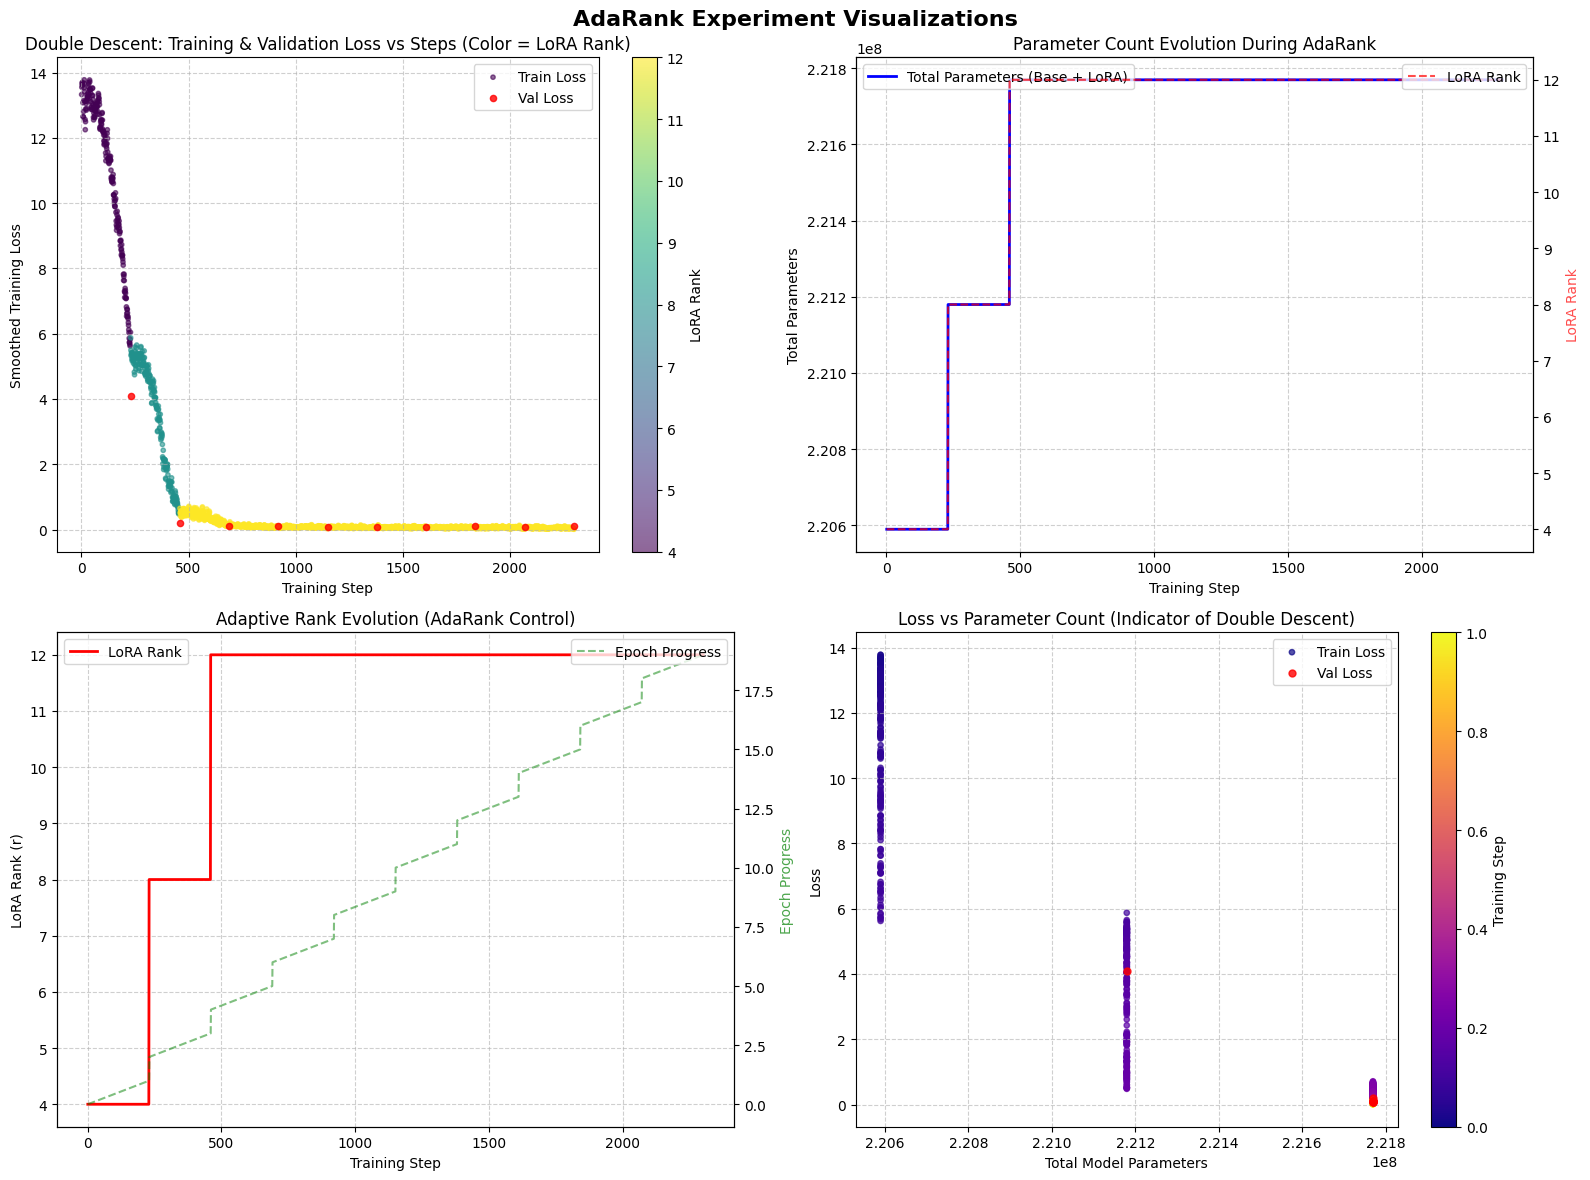

AdaRank Experiment Summary:
- Initial Rank: 4
- Final Rank: 12
- Max Rank Reached: 12
- Initial Parameters: 2.21e+08
- Final Parameters: 2.22e+08
- Max Train Loss: 14.2786
- Min Train Loss: 0.0020
- Max Val Loss: 4.0911
- Min Val Loss: 0.0771
- Final Val Loss: 0.0963


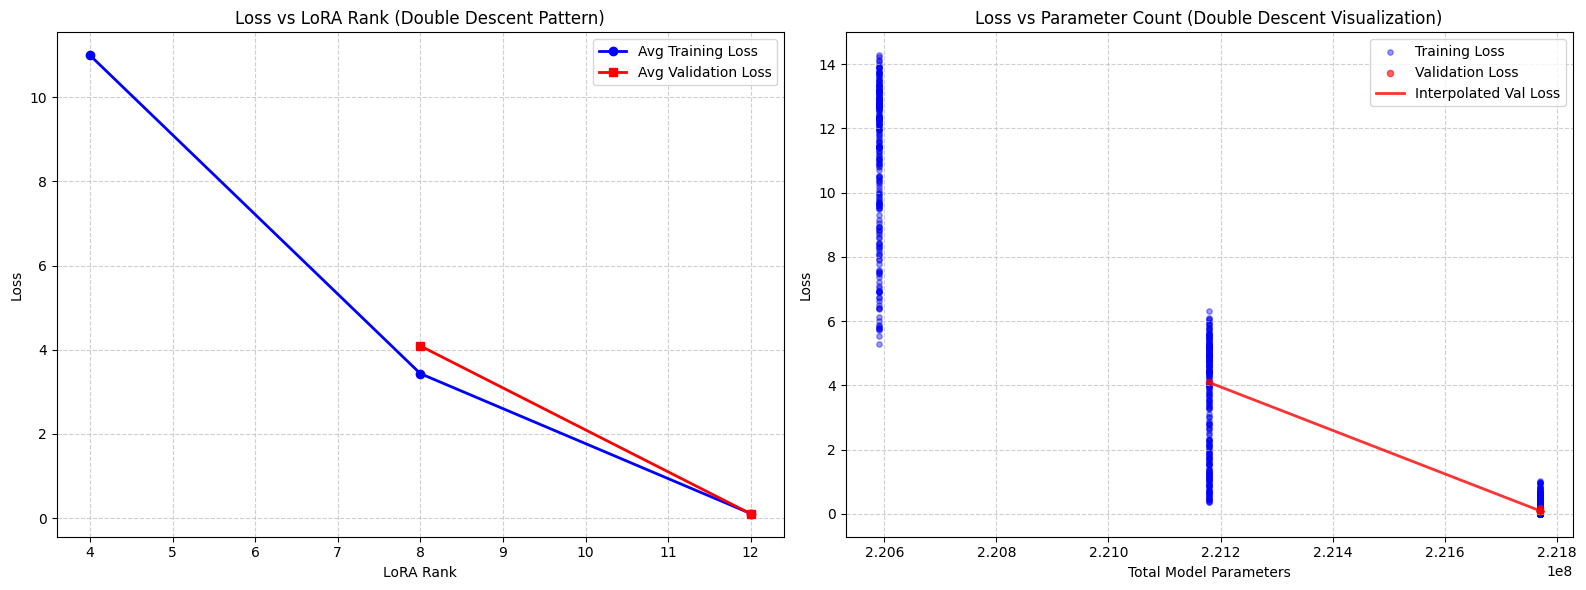

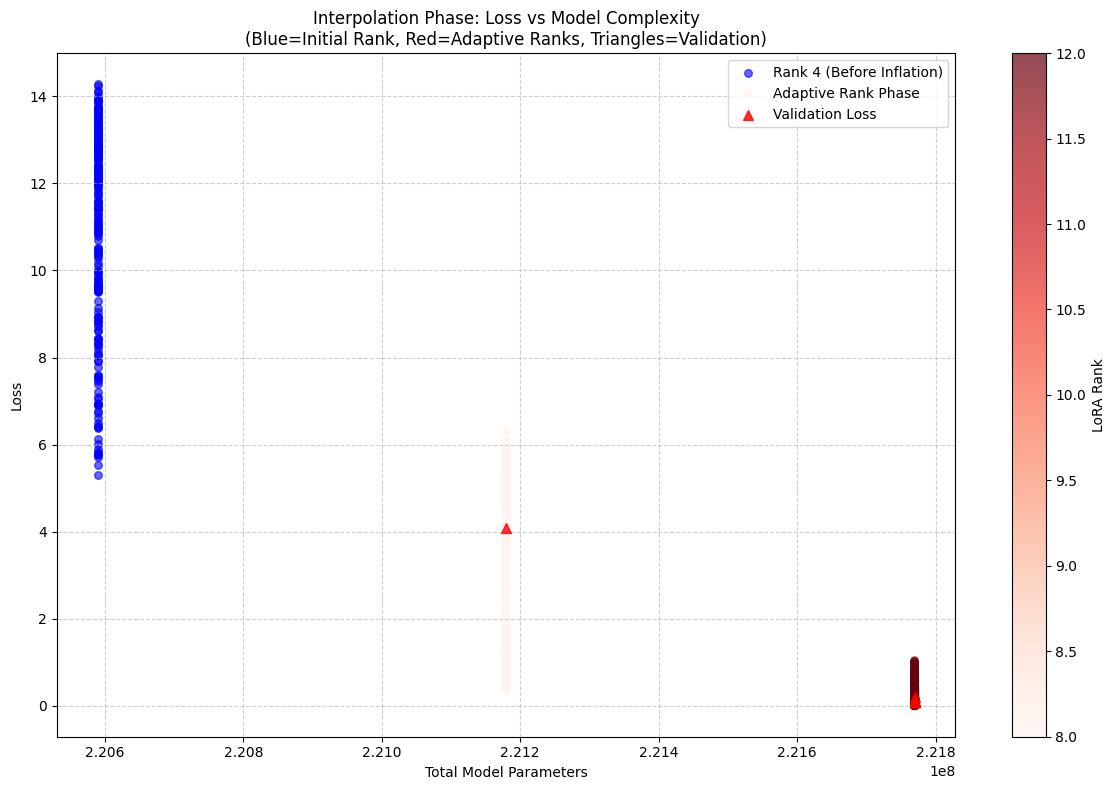

Interpolation Phase Analysis:
- Rank inflation started at step: 230
- Parameters at inflation start: 2.21e+08 (rank 8)


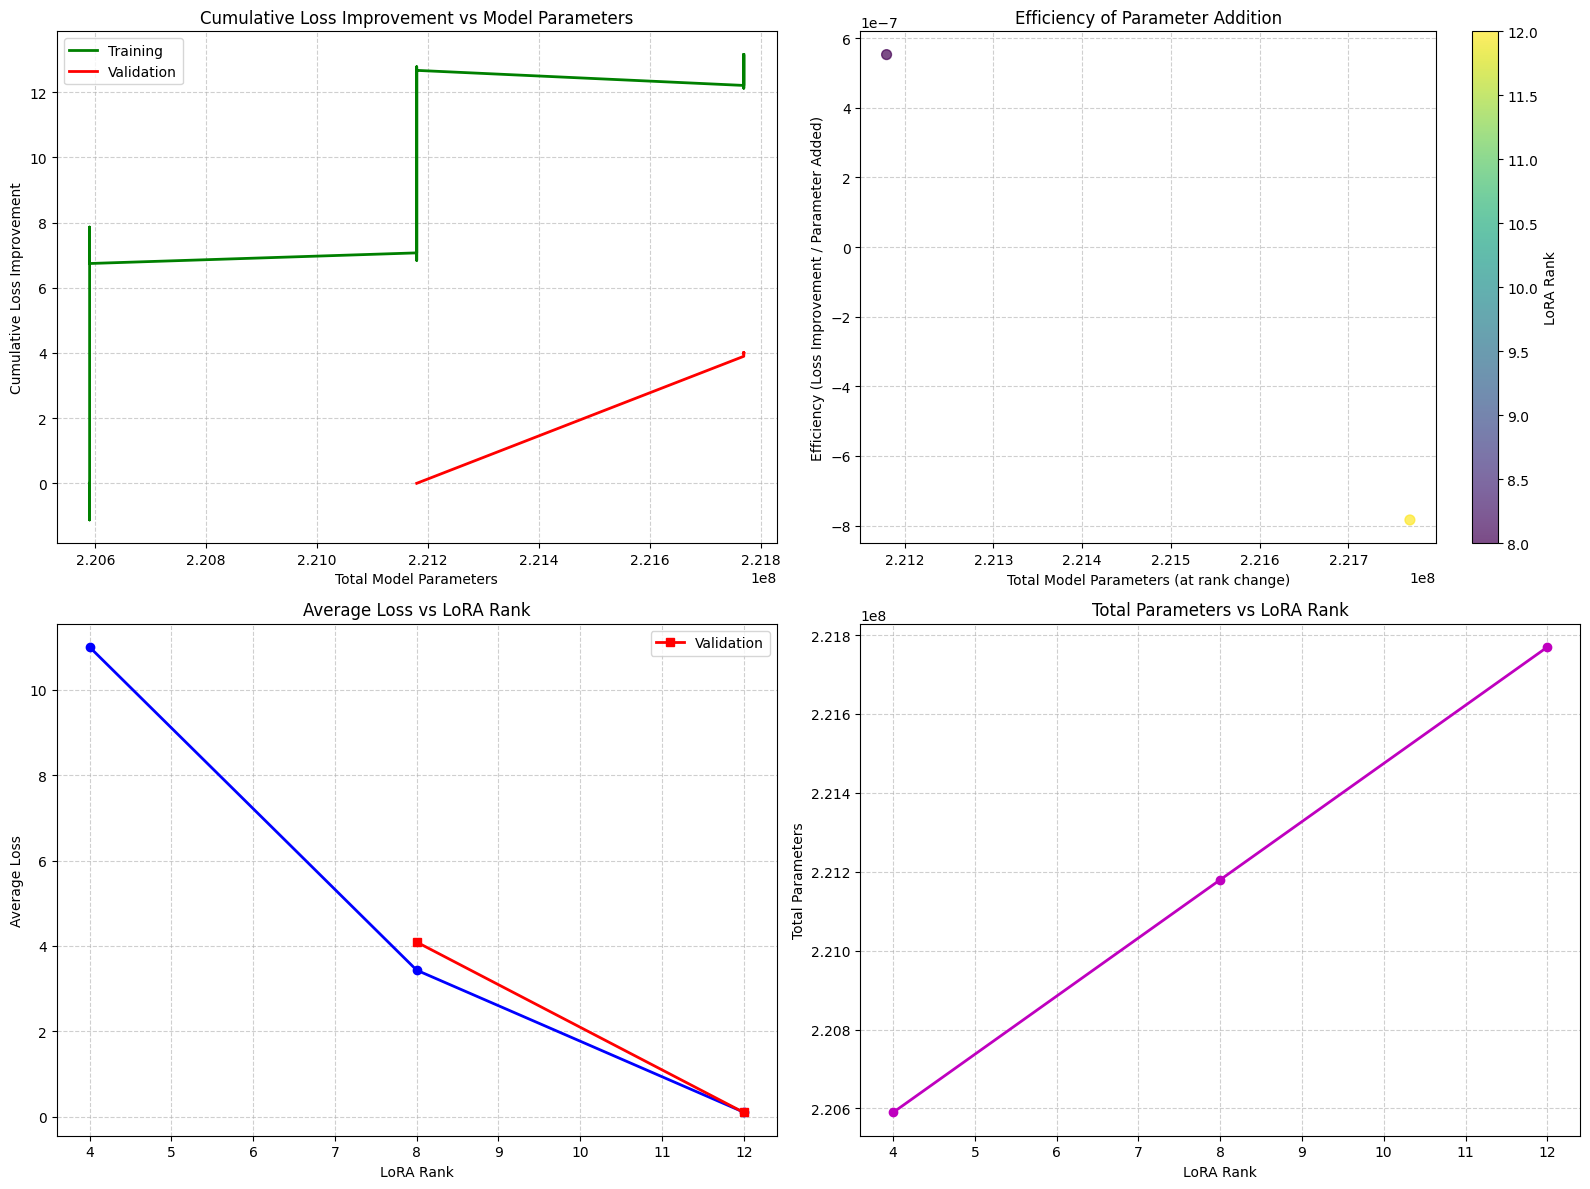

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

def plot_adarank_visualizations(results, smoothing_sigma=1.0):
    """
    Creates visualizations for AdaRank experiment results.
    
    Args:
        results: Output dictionary from run_experiment_pytorch
        smoothing_sigma: Standard deviation for Gaussian smoothing of loss curves
    """
    trajectory = results['trajectory']
    
    # Extract data from trajectory
    steps = [entry['step'] for entry in trajectory]
    losses = [entry['loss'] for entry in trajectory]
    ranks = [entry['rank'] for entry in trajectory]
    epochs = [entry['epoch'] for entry in trajectory]
    
    # Extract validation losses if available
    val_steps = [entry['step'] for entry in trajectory if 'val_loss' in entry]
    val_losses = [entry['val_loss'] for entry in trajectory if 'val_loss' in entry]
    val_ranks = [entry['rank'] for entry in trajectory if 'val_loss' in entry]
    
    # Calculate parameter count (approximation for T5-base with LoRA)
    base_model_params = 220_000_000  # Approx T5-base parameters
    lora_params_per_rank = 147456  # Approximate based on T5-base LoRA config
    total_params = [base_model_params + (rank * lora_params_per_rank) for rank in ranks]
    
    # Create the plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('AdaRank Experiment Visualizations', fontsize=16, fontweight='bold')

    # Plot 1: Double Descent Curve (Train Loss vs Steps with rank as color/intensity)
    ax1 = axes[0, 0]
    
    # Smooth the loss for better visualization
    smoothed_losses = gaussian_filter1d(losses, sigma=smoothing_sigma)
    
    scatter = ax1.scatter(steps, smoothed_losses, c=ranks, cmap='viridis', s=10, alpha=0.6, label='Train Loss')
    
    # Add validation loss if available
    if val_losses:
        ax1.scatter(val_steps, val_losses, c='red', s=20, alpha=0.8, label='Val Loss', zorder=5)
    
    ax1.set_xlabel('Training Step')
    ax1.set_ylabel('Smoothed Training Loss')
    ax1.set_title('Double Descent: Training & Validation Loss vs Steps (Color = LoRA Rank)')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()
    cbar1 = plt.colorbar(scatter, ax=ax1)
    cbar1.set_label('LoRA Rank')
    
    # Plot 2: Parameter Count vs Steps
    ax2 = axes[0, 1]
    ax2.plot(steps, total_params, 'b-', linewidth=2, label='Total Parameters (Base + LoRA)')
    ax2.set_xlabel('Training Step')
    ax2.set_ylabel('Total Parameters')
    ax2.set_title('Parameter Count Evolution During AdaRank')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_twin = ax2.twinx()
    ax2_twin.plot(steps, ranks, 'r--', alpha=0.7, label='LoRA Rank')
    ax2_twin.set_ylabel('LoRA Rank', color='r', alpha=0.7)
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    
    # Plot 3: Rank Evolution over Time
    ax3 = axes[1, 0]
    ax3.plot(steps, ranks, 'r-', linewidth=2, label='LoRA Rank')
    ax3.set_xlabel('Training Step')
    ax3.set_ylabel('LoRA Rank (r)')
    ax3.set_title('Adaptive Rank Evolution (AdaRank Control)')
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3_twin = ax3.twinx()
    ax3_twin.plot(steps, epochs, 'g--', alpha=0.5, label='Epoch Progress')
    ax3_twin.set_ylabel('Epoch Progress', color='g', alpha=0.7)
    ax3.legend(loc='upper left')
    ax3_twin.legend(loc='upper right')
    
    # Plot 4: Loss vs Parameter Count (Direct Double Descent visualization)
    ax4 = axes[1, 1]
    
    # Smooth loss for this plot too
    ax4.scatter(total_params, smoothed_losses, c=steps, cmap='plasma', s=15, alpha=0.7, label='Train Loss')
    
    # Add validation loss vs parameter count if available
    if val_losses:
        val_total_params = [base_model_params + (rank * lora_params_per_rank) for rank in val_ranks]
        ax4.scatter(val_total_params, val_losses, c='red', s=25, alpha=0.8, label='Val Loss', zorder=5)
    
    ax4.set_xlabel('Total Model Parameters')
    ax4.set_ylabel('Loss')
    ax4.set_title('Loss vs Parameter Count (Indicator of Double Descent)')
    ax4.grid(True, linestyle='--', alpha=0.6)
    ax4.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    ax4.legend()
    cbar4 = plt.colorbar(plt.cm.ScalarMappable(cmap='plasma'), ax=ax4)
    cbar4.set_label('Training Step')

    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"AdaRank Experiment Summary:")
    print(f"- Initial Rank: {ranks[0]}")
    print(f"- Final Rank: {ranks[-1]}")
    print(f"- Max Rank Reached: {max(ranks)}")
    print(f"- Initial Parameters: {total_params[0]:.2e}")
    print(f"- Final Parameters: {total_params[-1]:.2e}")
    print(f"- Max Train Loss: {max(losses):.4f}")
    print(f"- Min Train Loss: {min(losses):.4f}")
    if val_losses:
        print(f"- Max Val Loss: {max(val_losses):.4f}")
        print(f"- Min Val Loss: {min(val_losses):.4f}")
        print(f"- Final Val Loss: {val_losses[-1]:.4f}")


def plot_double_descent_detailed(results):
    """
    Creates a detailed double descent visualization focusing on the relationship 
    between model complexity (rank) and both training and validation loss.
    """
    trajectory = results['trajectory']
    
    # Extract data
    steps = [entry['step'] for entry in trajectory]
    losses = [entry['loss'] for entry in trajectory]
    ranks = [entry['rank'] for entry in trajectory]
    
    # Extract validation losses if available
    val_steps = [entry['step'] for entry in trajectory if 'val_loss' in entry]
    val_losses = [entry['val_loss'] for entry in trajectory if 'val_loss' in entry]
    val_ranks = [entry['rank'] for entry in trajectory if 'val_loss' in entry]
    
    # Calculate parameter count
    base_model_params = 220_000_000
    lora_params_per_rank = 147456
    total_params = [base_model_params + (rank * lora_params_per_rank) for rank in ranks]
    val_total_params = [base_model_params + (rank * lora_params_per_rank) for rank in val_ranks]
    
    # Get unique ranks and corresponding losses for cleaner visualization
    unique_ranks = sorted(list(set(ranks)))
    rank_to_train_loss = {}
    for r, l in zip(ranks, losses):
        if r not in rank_to_train_loss:
            rank_to_train_loss[r] = []
        rank_to_train_loss[r].append(l)
    
    # Average train losses per rank
    avg_train_losses = [np.mean(rank_to_train_loss[r]) for r in unique_ranks]
    
    # For validation losses
    if val_losses:
        rank_to_val_loss = {}
        for r, l in zip(val_ranks, val_losses):
            if r not in rank_to_val_loss:
                rank_to_val_loss[r] = []
            rank_to_val_loss[r].append(l)
        
        avg_val_losses = [np.mean(rank_to_val_loss[r]) for r in unique_ranks if r in rank_to_val_loss]
        unique_val_ranks = [r for r in unique_ranks if r in rank_to_val_loss]
        val_param_counts = [base_model_params + (rank * lora_params_per_rank) for rank in unique_val_ranks]
    
    # Create detailed plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left plot: Loss vs Rank
    ax1.plot(unique_ranks, avg_train_losses, 'b-o', label='Avg Training Loss', linewidth=2, markersize=6)
    if val_losses and avg_val_losses:
        ax1.plot(unique_val_ranks, avg_val_losses, 'r-s', label='Avg Validation Loss', linewidth=2, markersize=6)
    ax1.set_xlabel('LoRA Rank')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss vs LoRA Rank (Double Descent Pattern)')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()
    
    # Right plot: Loss vs Parameter Count with interpolation
    ax2.scatter(total_params, losses, c='blue', alpha=0.4, s=15, label='Training Loss', rasterized=True)
    if val_losses:
        ax2.scatter(val_total_params, val_losses, c='red', alpha=0.6, s=20, label='Validation Loss', rasterized=True)
    
    # Add interpolated validation curve if we have enough points
    if val_losses and len(val_losses) > 1:
        # Sort by parameter count for interpolation
        sorted_pairs = sorted(zip(val_total_params, val_losses))
        if len(sorted_pairs) > 1:
            sorted_params, sorted_losses = zip(*sorted_pairs)
            # Only interpolate if we have unique x values
            unique_sorted = {}
            for p, l in zip(sorted_params, sorted_losses):
                if p not in unique_sorted:
                    unique_sorted[p] = []
                unique_sorted[p].append(l)
            
            unique_params = sorted(unique_sorted.keys())
            avg_unique_losses = [np.mean(unique_sorted[p]) for p in unique_params]
            
            if len(unique_params) > 1:
                f_interp = interp1d(unique_params, avg_unique_losses, kind='linear', bounds_error=False, fill_value='extrapolate')
                smooth_params = np.linspace(min(unique_params), max(unique_params), 300)
                smooth_losses = f_interp(smooth_params)
                ax2.plot(smooth_params, smooth_losses, 'r-', linewidth=2, label='Interpolated Val Loss', alpha=0.8)
    
    ax2.set_xlabel('Total Model Parameters')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss vs Parameter Count (Double Descent Visualization)')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


def plot_interpolation_phase(results):
    """
    Creates a focused visualization around the interpolation threshold,
    showing the relationship between model complexity (LoRA rank) and loss.
    """
    trajectory = results['trajectory']
    
    steps = [entry['step'] for entry in trajectory]
    losses = [entry['loss'] for entry in trajectory]
    ranks = [entry['rank'] for entry in trajectory]
    
    # Extract validation losses if available
    val_steps = [entry['step'] for entry in trajectory if 'val_loss' in entry]
    val_losses = [entry['val_loss'] for entry in trajectory if 'val_loss' in entry]
    val_ranks = [entry['rank'] for entry in trajectory if 'val_loss' in entry]
    
    # Calculate parameter count
    base_model_params = 220_000_000
    lora_params_per_rank = 147456
    total_params = [base_model_params + (rank * lora_params_per_rank) for rank in ranks]
    val_total_params = [base_model_params + (rank * lora_params_per_rank) for rank in val_ranks]
    
    # Find the point where rank starts increasing significantly (interpolation threshold proxy)
    unique_ranks = sorted(list(set(ranks)))
    if len(unique_ranks) > 1:
        initial_rank = unique_ranks[0]
        first_inflation_idx = next((i for i, r in enumerate(ranks) if r > initial_rank), len(ranks))
        
        # Create the plot
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        
        # Plot training data
        ax.scatter(total_params[:first_inflation_idx], losses[:first_inflation_idx], 
                  c='blue', label=f'Rank {initial_rank} (Before Inflation)', alpha=0.6, s=30)
        
        # After inflation
        if first_inflation_idx < len(total_params):
            scatter = ax.scatter(total_params[first_inflation_idx:], losses[first_inflation_idx:], 
                               c=ranks[first_inflation_idx:], cmap='Reds', label='Adaptive Rank Phase', alpha=0.7, s=30)
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('LoRA Rank')
        
        # Add validation data if available
        if val_losses:
            ax.scatter(val_total_params, val_losses, c='red', marker='^', s=50, alpha=0.8, 
                      label='Validation Loss', zorder=5)
        
        ax.set_xlabel('Total Model Parameters')
        ax.set_ylabel('Loss')
        ax.set_title('Interpolation Phase: Loss vs Model Complexity\n(Blue=Initial Rank, Red=Adaptive Ranks, Triangles=Validation)')
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"Interpolation Phase Analysis:")
        print(f"- Rank inflation started at step: {steps[first_inflation_idx] if first_inflation_idx < len(steps) else 'N/A'}")
        print(f"- Parameters at inflation start: {total_params[first_inflation_idx]:.2e} (rank {ranks[first_inflation_idx] if first_inflation_idx < len(ranks) else 'N/A'})")


def plot_parameter_efficiency(results):
    """
    Compares parameter efficiency by showing loss improvement per parameter added.
    """
    trajectory = results['trajectory']
    
    steps = [entry['step'] for entry in trajectory]
    losses = [entry['loss'] for entry in trajectory]
    ranks = [entry['rank'] for entry in trajectory]
    
    # Extract validation losses if available
    val_steps = [entry['step'] for entry in trajectory if 'val_loss' in entry]
    val_losses = [entry['val_loss'] for entry in trajectory if 'val_loss' in entry]
    val_ranks = [entry['rank'] for entry in trajectory if 'val_loss' in entry]
    
    # Calculate parameter count
    base_model_params = 220_000_000
    lora_params_per_rank = 147456
    total_params = [base_model_params + (rank * lora_params_per_rank) for rank in ranks]
    val_total_params = [base_model_params + (rank * lora_params_per_rank) for rank in val_ranks]
    
    # Calculate cumulative parameter efficiency (loss improvement per parameter added)
    initial_loss = losses[0]
    loss_improvement = [initial_loss - loss for loss in losses]
    
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Loss improvement vs parameters
    ax1.plot(total_params, loss_improvement, 'g-', linewidth=2, label='Training')
    if val_losses:
        initial_val_loss = val_losses[0] if val_losses else initial_loss
        val_loss_improvement = [initial_val_loss - loss for loss in val_losses]
        ax1.plot(val_total_params, val_loss_improvement, 'r-', linewidth=2, label='Validation')
    ax1.set_xlabel('Total Model Parameters')
    ax1.set_ylabel('Cumulative Loss Improvement')
    ax1.set_title('Cumulative Loss Improvement vs Model Parameters')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    ax1.legend()
    
    # Rank vs efficiency (loss improvement per rank unit)
    rank_efficiency = []
    for i in range(1, len(loss_improvement)):
        if ranks[i] != ranks[i-1]:  # Only calculate when rank changed
            param_change = total_params[i] - total_params[i-1]
            loss_change = loss_improvement[i] - loss_improvement[i-1]
            if param_change > 0:
                efficiency = loss_change / param_change
                rank_efficiency.append((total_params[i], efficiency, ranks[i]))
    
    if rank_efficiency:
        params_at_change, eff_values, eff_ranks = zip(*rank_efficiency)
        scatter2 = ax2.scatter(params_at_change, eff_values, c=eff_ranks, cmap='viridis', s=50, alpha=0.7)
        ax2.set_xlabel('Total Model Parameters (at rank change)')
        ax2.set_ylabel('Efficiency (Loss Improvement / Parameter Added)')
        ax2.set_title('Efficiency of Parameter Addition')
        ax2.grid(True, linestyle='--', alpha=0.6)
        ax2.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
        cbar2 = plt.colorbar(scatter2, ax=ax2)
        cbar2.set_label('LoRA Rank')
    
    # Loss vs rank with smoothing
    unique_ranks = sorted(list(set(ranks)))
    rank_to_train_loss = {}
    for r, l in zip(ranks, losses):
        if r not in rank_to_train_loss:
            rank_to_train_loss[r] = []
        rank_to_train_loss[r].append(l)
    
    avg_train_losses = [np.mean(rank_to_train_loss[r]) for r in unique_ranks]
    ax3.plot(unique_ranks, avg_train_losses, 'b-o', linewidth=2, markersize=6)
    
    if val_losses:
        rank_to_val_loss = {}
        for r, l in zip(val_ranks, val_losses):
            if r not in rank_to_val_loss:
                rank_to_val_loss[r] = []
            rank_to_val_loss[r].append(l)
        
        avg_val_losses = [np.mean(rank_to_val_loss[r]) for r in unique_ranks if r in rank_to_val_loss]
        unique_val_ranks = [r for r in unique_ranks if r in rank_to_val_loss]
        ax3.plot(unique_val_ranks, avg_val_losses, 'r-s', linewidth=2, markersize=6, label='Validation')
    
    ax3.set_xlabel('LoRA Rank')
    ax3.set_ylabel('Average Loss')
    ax3.set_title('Average Loss vs LoRA Rank')
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.legend()
    
    # Parameter count vs rank
    unique_params = [base_model_params + (rank * lora_params_per_rank) for rank in unique_ranks]
    ax4.plot(unique_ranks, unique_params, 'm-o', linewidth=2, markersize=6)
    ax4.set_xlabel('LoRA Rank')
    ax4.set_ylabel('Total Parameters')
    ax4.set_title('Total Parameters vs LoRA Rank')
    ax4.grid(True, linestyle='--', alpha=0.6)
    ax4.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    plt.tight_layout()
    plt.show()


# Example usage after running your experiment:
plot_adarank_visualizations(results)
plot_double_descent_detailed(results)
plot_interpolation_phase(results)
plot_parameter_efficiency(results)